# Re-Inventing QFT

## Prerequisites

### Install and import Quantastica QPS API

In [1]:
import sys

try:
  from quantastica.qps_api import QPS
except:
  !{sys.executable} -m pip install quantastica-qps-api
  from quantastica.qps_api import QPS

Fore details about quantastica-qps-api package, see: https://pypi.org/project/quantastica-qps-api/


### Register your QPS API key

Uncomment following line, add your API key and run:

In [2]:
# QPS.save_account("YOUR_API_TOKEN")

**WARNING:** Run this only once on your machine and then remove this cell. Don't keep your API key in the notebook for security reasons.

## Utility/helper functions

In [3]:
import numpy as np
import cmath
from matplotlib import pyplot as plt
from IPython.display import SVG

def plot_vector_pair(initial_vector, final_vector, title=""):
    fig = plt.figure(figsize=(16, 8))

    fig.suptitle(title)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.grid(True)
    ax1.bar([str(i) for i in range(len(initial_vector))], np.abs(initial_vector))

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.grid(True)
    ax2.plot([str(i) for i in range(len(final_vector))], np.round(np.sin(np.angle(final_vector)), 5))
    
    fig.tight_layout()
    plt.show()


def display_circuit(qasm):
    circuit_svg = QPS.converter.convert(qasm, "qasm", "svg-inline")
        
    display(SVG(circuit_svg))


## Step 1: classically generate input and output data encoded into state vectors:


*** 3-Qubit ***


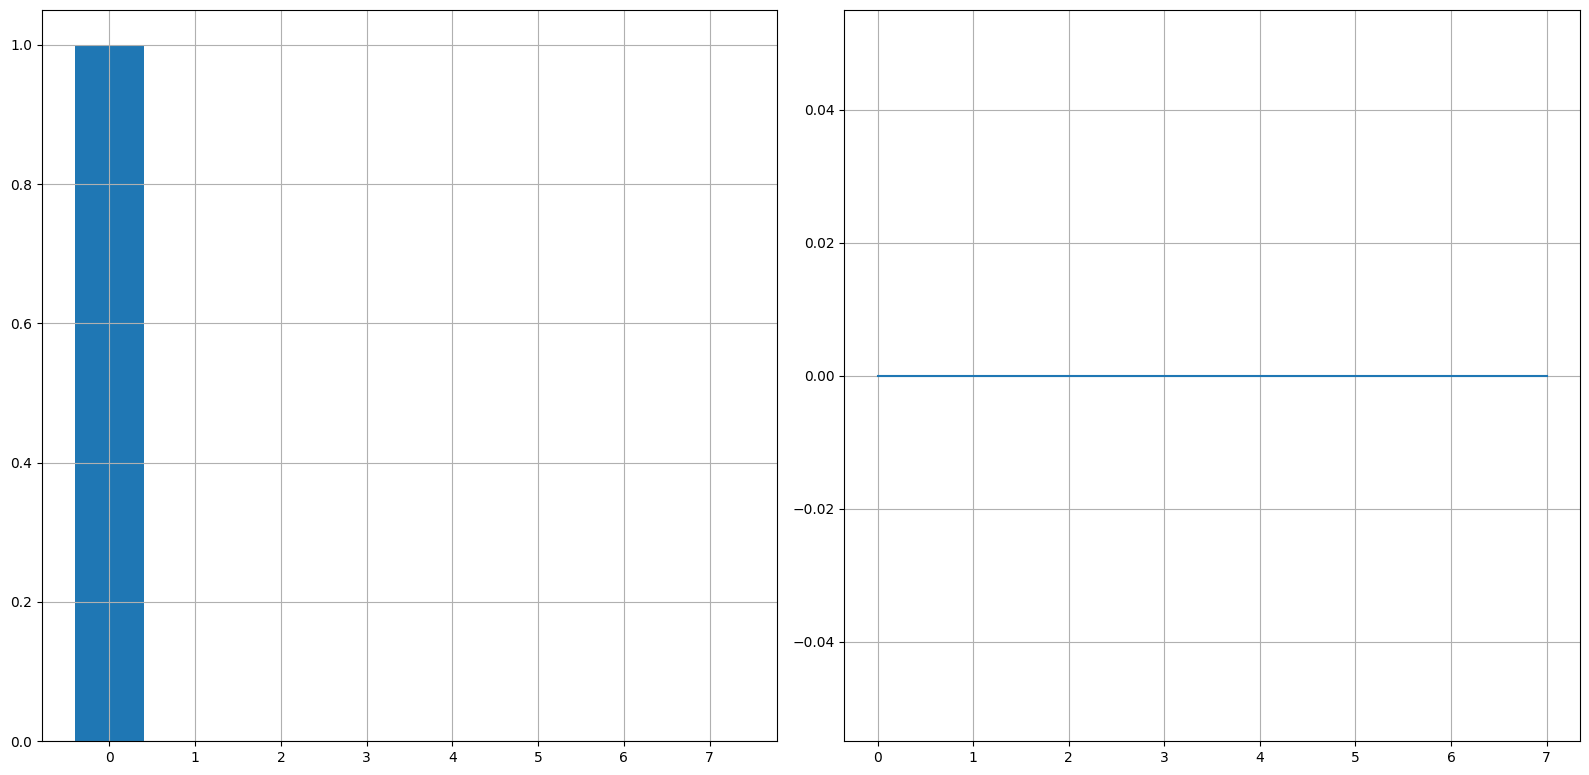

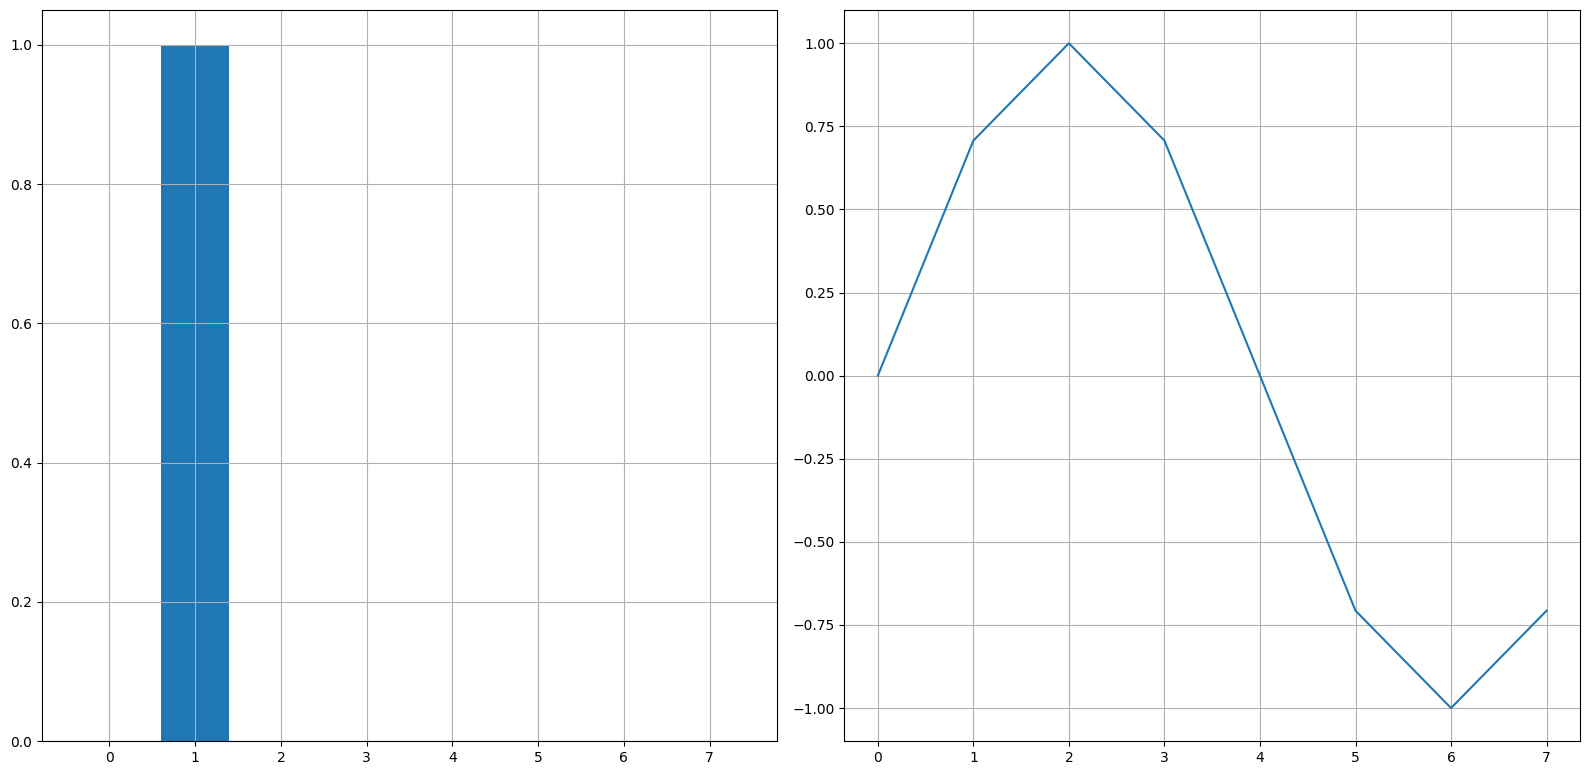

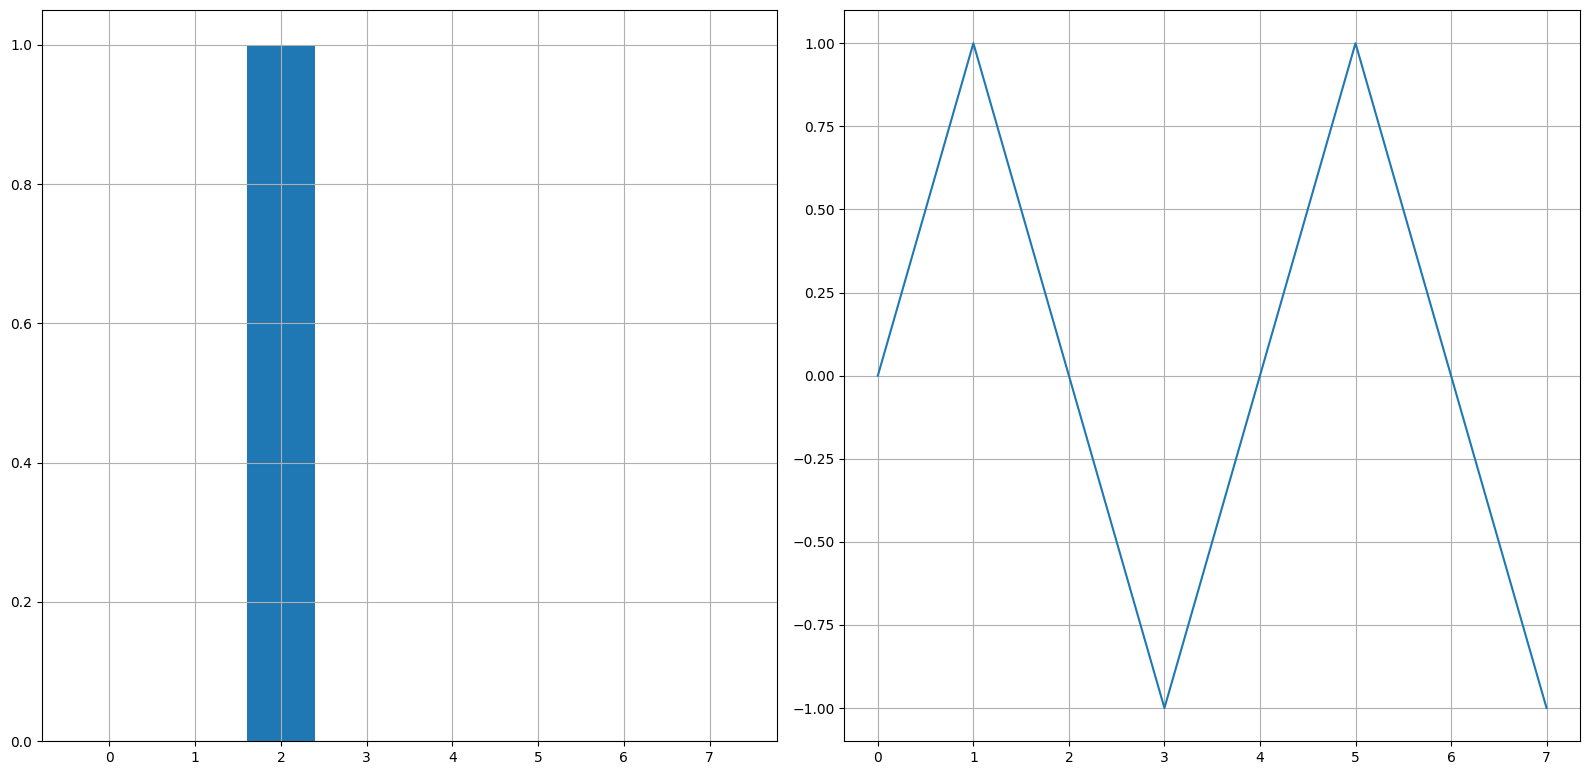

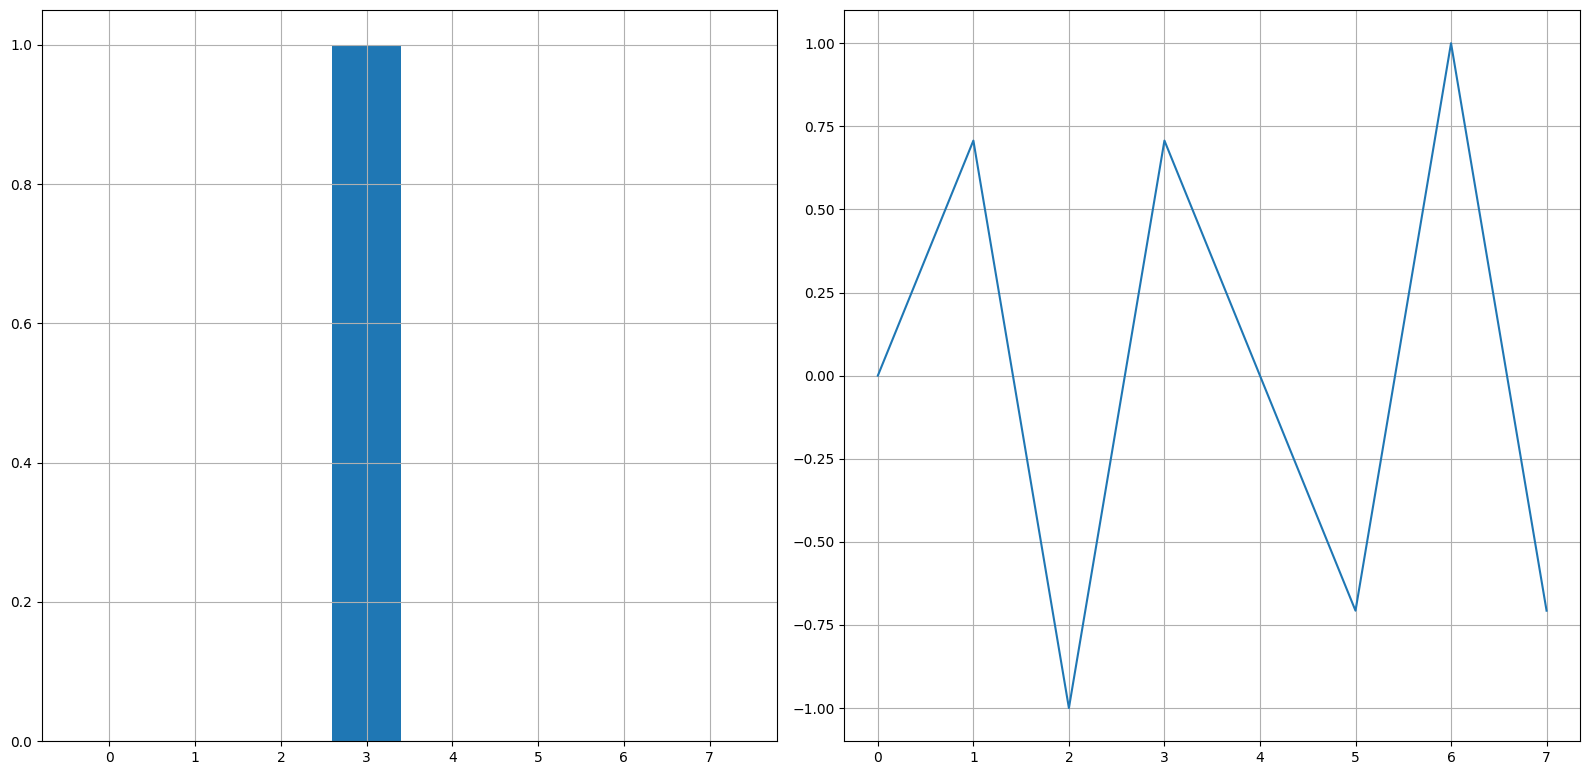

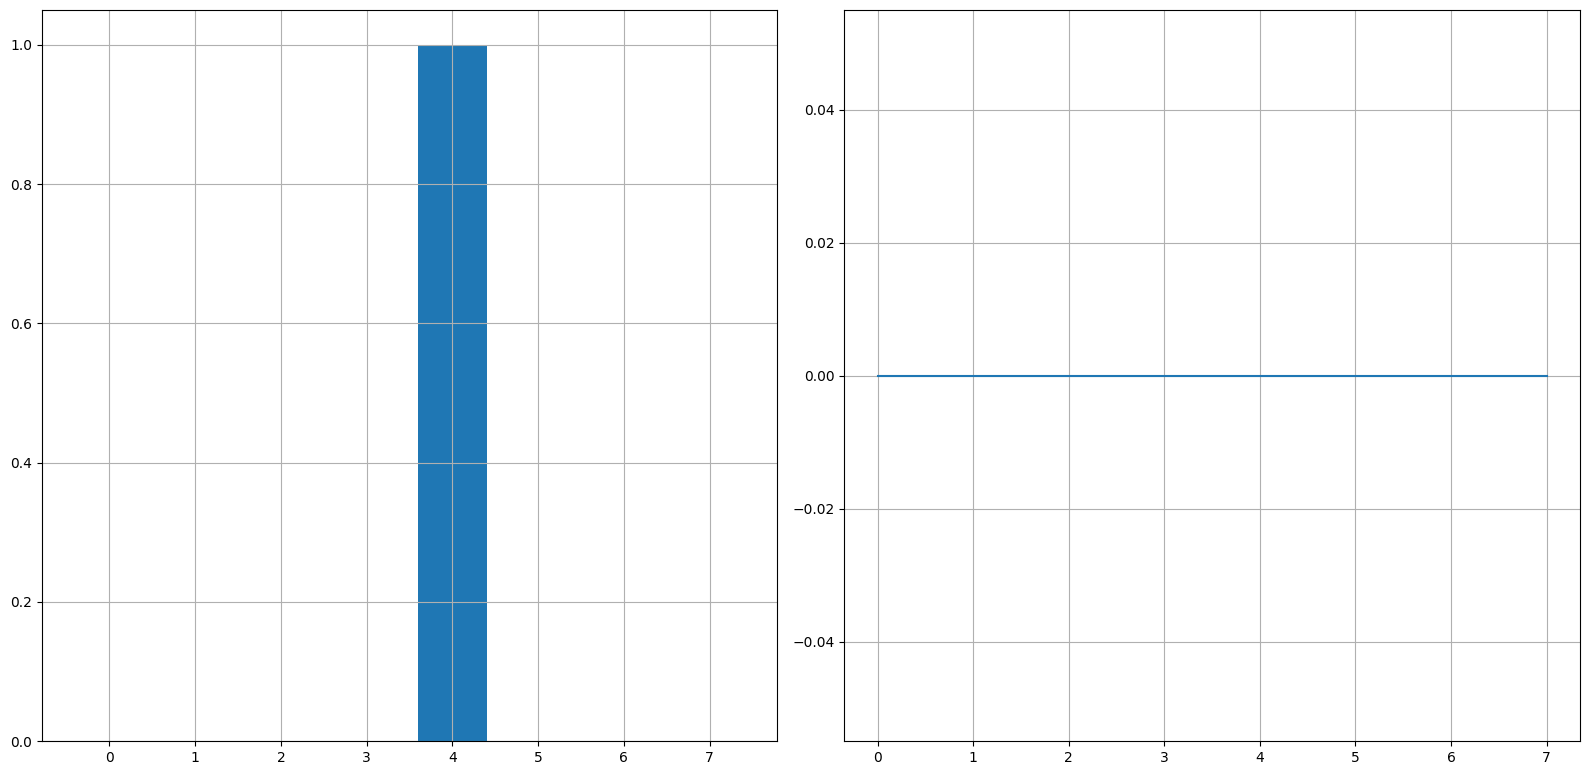

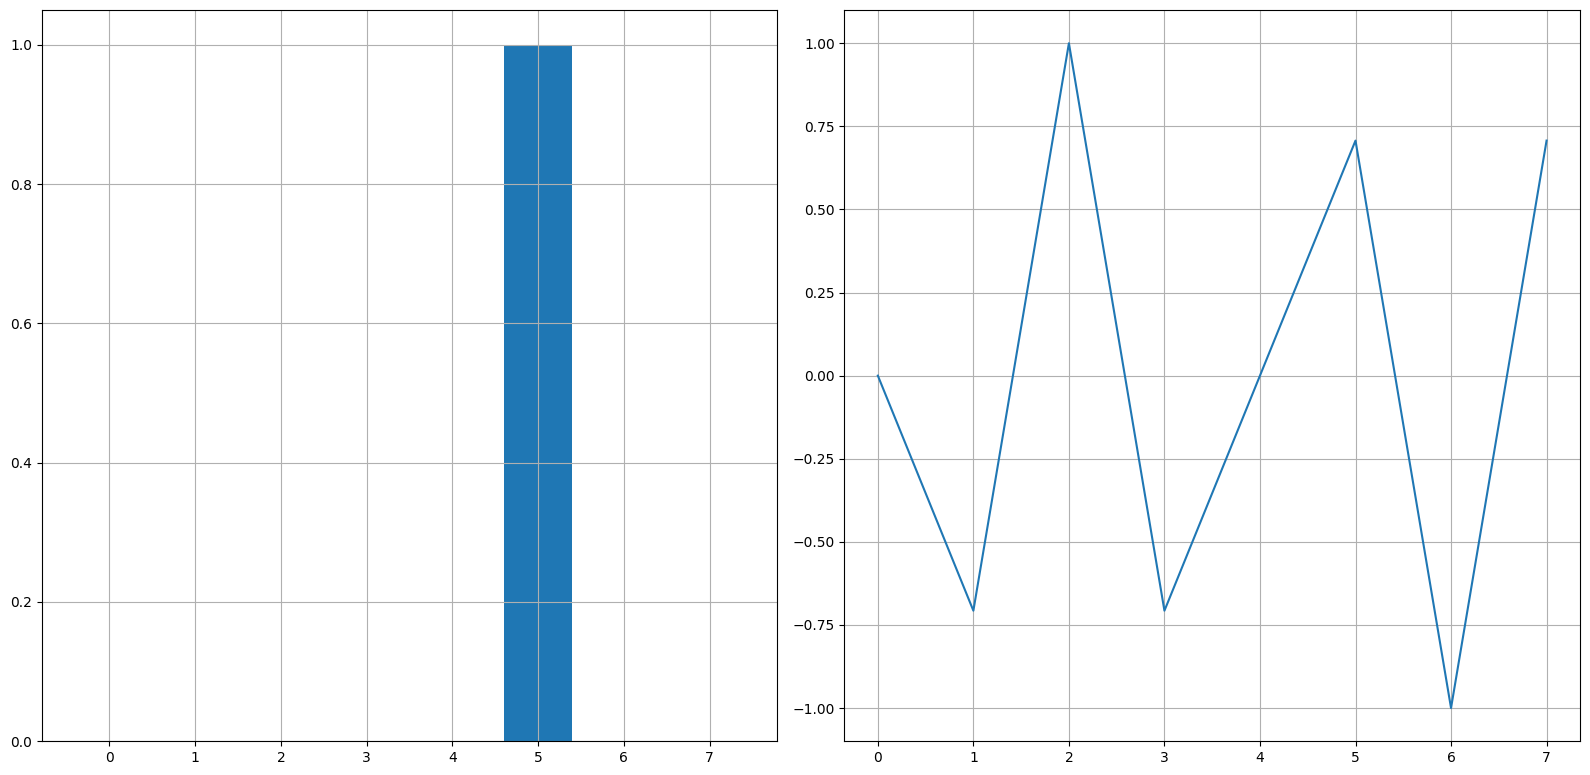

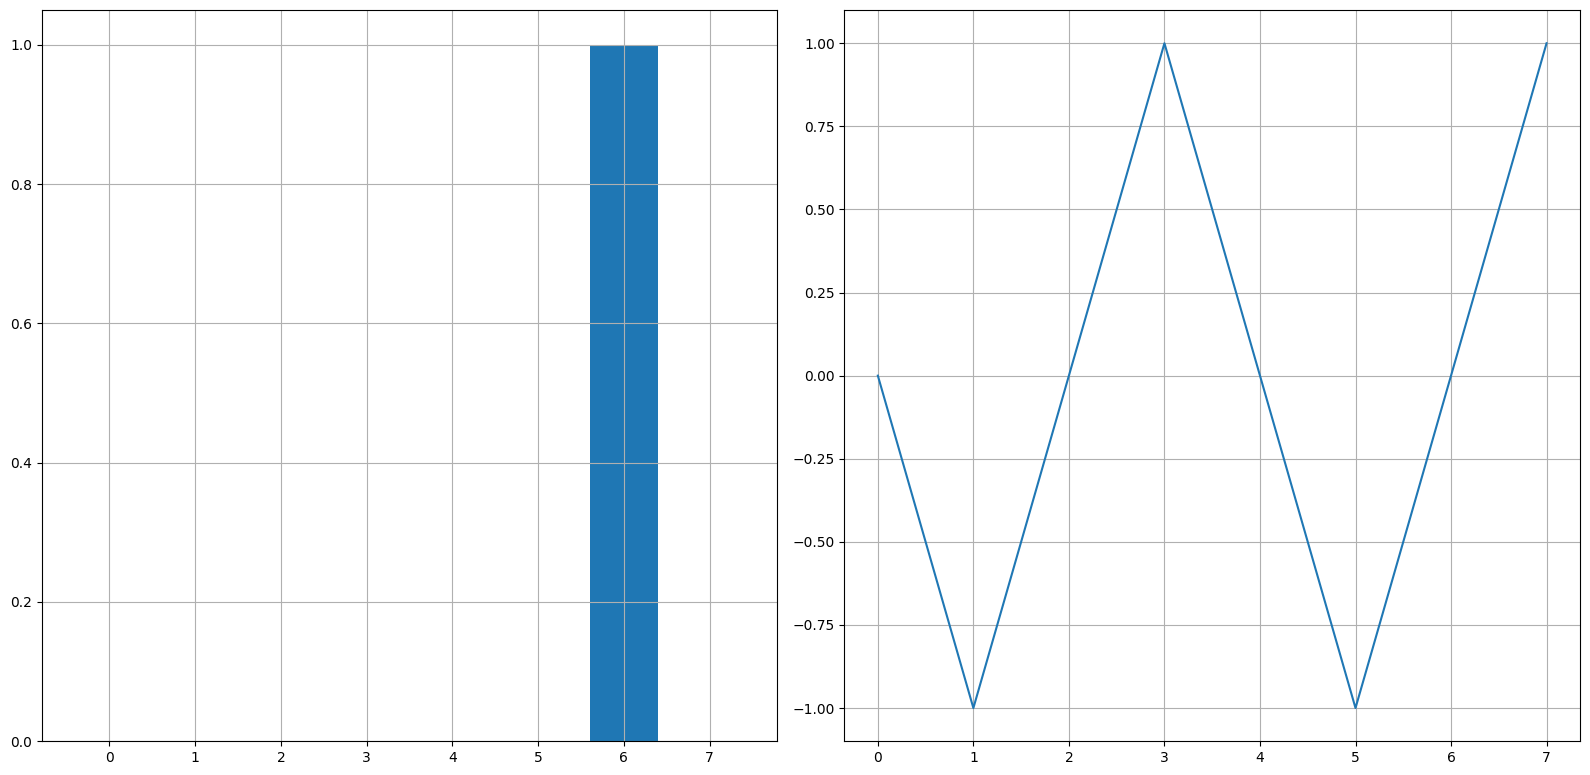

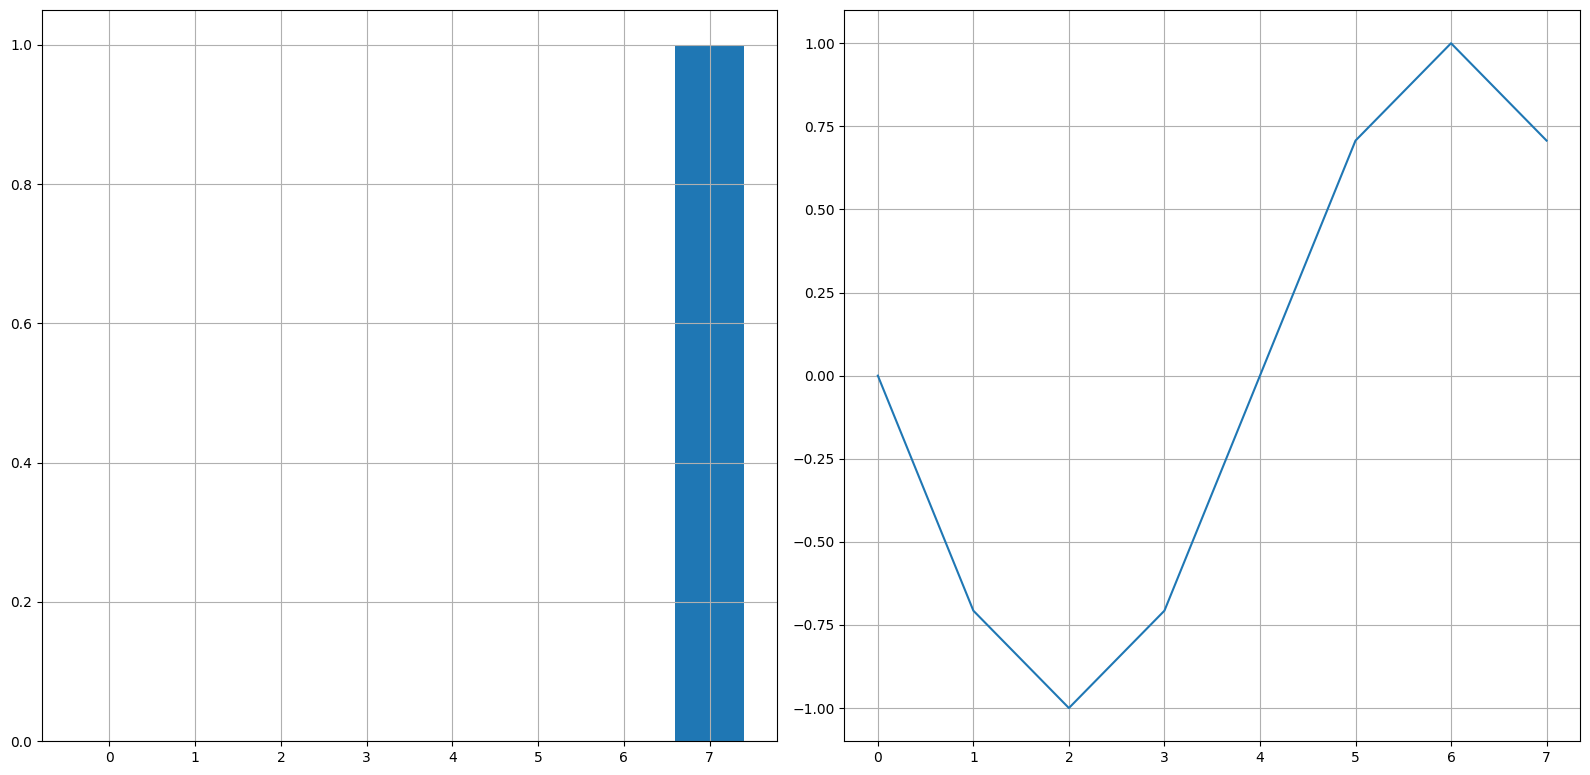

In [4]:
def create_vector_pairs(num_qubits, inverse=False):
    vector_pairs = []

    print("\n*** " + str(num_qubits) + "-Qubit ***")
    
    for frequency in range(2**num_qubits):
        # input vector
        input_vector = np.zeros(2**num_qubits, dtype=complex).tolist()
        input_vector[frequency] = 1+0j

        # output vector
        output_vector = np.fft.ifft(input_vector, norm="ortho").tolist()
        
        if(inverse):
            vector_pairs.append([output_vector, input_vector])
        else:
            vector_pairs.append([input_vector, output_vector])
            
        plot_vector_pair(input_vector, output_vector)
        
    return vector_pairs


# Generate vectors using classical FFT

NUM_QUBITS = 3
inverse = False

vector_pairs = create_vector_pairs(num_qubits=NUM_QUBITS, inverse=inverse)


## Step2: Reverse-engineer quantum circuit from vectors

Running...

Output:

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
h q[1];
h q[2];
swap q[0], q[2];
h q[1];
cu1 (1.570796326794897) q[0], q[1];
h q[1];
cu1 (0.785398163397449) q[0], q[2];
cu1 (1.570796326794897) q[1], q[2];
h q[2];



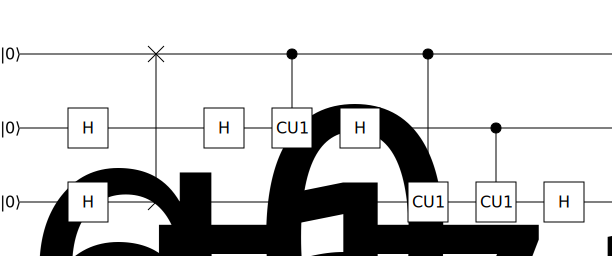

In [5]:
from quantastica.qps_api import QPS


def circuit_from_vector_pairs(vector_pairs, generator_settings):
    print("Running...\n")

    job_id = QPS.generator.circuit_from_vectors(vector_pairs, settings = generator_settings)

    job = QPS.generator.get_job(job_id, wait=True)

    job_status = job["status"]
    job_output = job["output"]

    if(job_status == "error"):
        raise Exception(job_output["message"])
    else:
        circuit = job_output["circuits"][0]
        qasm = circuit["qasm"]
        print("Output:\n")
        print(qasm)
        display_circuit(qasm)

    return circuit

#
# Reverse-engineer circuit from vectors
#
# This method is slow for more than 3 qubits, but returns optimal solution:
#
resulting_circuit = circuit_from_vector_pairs(vector_pairs, generator_settings = { "single_solution": True, "pre_processing": "experimental1", "instruction_set": ["h", "cu1", "swap"] })

#
# For more than 3 qubits please use following settings:
#
# circuit_from_vector_pairs(vector_pairs, generator_settings = { "single_solution": True, "strategy": "strategy_b" })
#
# This strategy will return deeper circuit (with u3,cx instruction set) which can be transpiled/optimmized later



Resulting circuit is QFT.

**Note** that gates in the resulting circuit are arranged differently than what you can usually see in textbooks (swap gates are usually at the end of the circuit etc.), but circuit is perfectly valid QFT. 

## Step3 (Optional) - Transpile to IONQ native instruction set


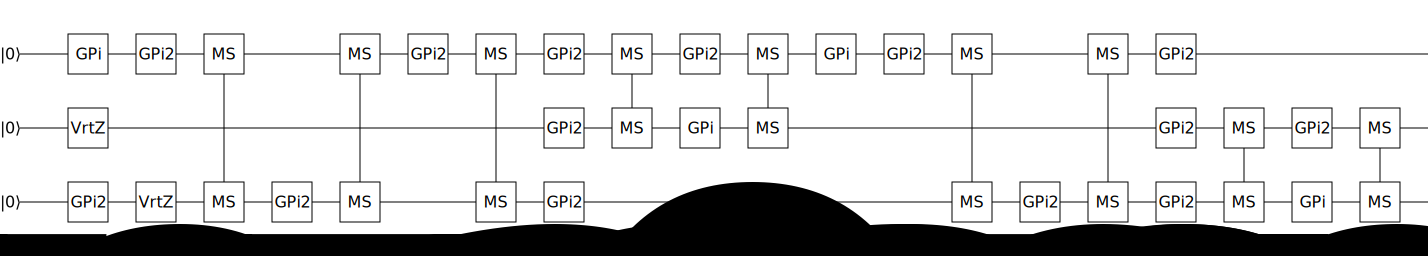

In [6]:
instruction_set = ["gpi", "gpi2", "vz", "ms"]

job_id = QPS.generator.transpile(resulting_circuit["qasm"], method="replace_blocks", method_options={ "block_size": 2, "two_pass": False }, settings = { "instruction_set": instruction_set, "pre_processing": None, "diff_method": "ignorephase" })

job = QPS.generator.get_job(job_id, wait=True)

job_status = job["status"]
job_output = job["output"]

if(job_status == "error"):
    raise Exception(job_output["message"])

job_output = job["output"]
if(len(job_output["circuits"]) == 0):
    raise Exception("No solutions")

transpiled_circuit = job_output["circuits"][0]

transpiled_qasm = transpiled_circuit["qasmExt"]

display_circuit(transpiled_qasm)
